In [1]:
import pertpy as pt


/software/cellgen/team298/ls34/sccoda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import warnings

import decoupler as dc
import scanpy as sc

warnings.filterwarnings("ignore")

## Dataset

In [3]:
adata=sc.read_h5ad('/nfs/team298/ls34/adult_skin/final_adatas/adata_combined_new.h5ad.final.filtered.scrna')
adata


AnnData object with n_obs × n_vars = 1730938 × 32732
    obs: 'sample_id', 'barcode', 'GSE', 'Site_status', 'Patient_status', 'Location', 'Age', 'Sex', 'n_genes', 'dataset_id', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'QC_hi', 'QC_mid', 'lvl5_annotation', 'Mapping_status', 'scanvi_predictions', 'lvl5_annotation_new', 'lvl5_annotation_new2', 'lvl5_annotation_new3', 'lvl5_annotation_new_archive', 'lvl5_annotation_new_preoprhan', 'lvl5_annotation_new10', 'lvl5_annotation_new11', 'test', 'test_n', 'lvl5_annotation_new12', 'lvl5_annotation_new13', 'lvl4_annotation', 'lvl0', 'temp', 't', 'leiden_res0.1', 'Site_status_simple', 'StatusMilo', 'atlas_status', 'atlas_status_reynolds', 'atlas_status_reynolds_simple', 'atlas_status_simple', 'atlas_status_simple2', 'Site_status_binary', 'lvl1_new'
    uns: '

In [4]:
adata.obs["atlas_status_simple"].value_counts()

atlas_status_simple
Eczema_Lesional                                   190291
Psoriasis_Lesional                                145006
Psoriasis_PostRx                                   96485
Eczema_Nonlesional                                 92297
Eczema_PostRx                                      10920
Healthy_Nonlesional_prurigo_calugura_GSE213849      2490
Eczema_Lesional_prurigo_calugura_GSE213849          1400
Name: count, dtype: int64

In [5]:
adata.obs["Site_status_binary"]=adata.obs["Site_status_simple"]
adata.obs.Site_status_binary.value_counts()



Site_status_binary
Nonlesional    1286836
Lesional        336697
PostRx          107405
Name: count, dtype: int64

In [6]:
adata = adata[adata.obs["Site_status_binary"] == "Lesional", :].copy()
adata.obs.Site_status_binary.value_counts()



Site_status_binary
Lesional    336697
Name: count, dtype: int64

In [7]:
adata.obs["Patient"]=adata.obs["sample_id"]
adata.obs["Sample"]=adata.obs["sample_id"]
patient_counts = adata.obs.groupby("Patient").size()
patient_counts


Patient
AD1           4471
AD2           3671
AD3           1740
AD4           2884
AD5           5218
              ... 
SKN8090589    7063
SKN8090591    6446
SKN8090604    4298
SKN8090605    7638
SKN8090607    6061
Length: 63, dtype: int64

In [8]:
mask = adata.obs["Patient"].map(patient_counts).astype(int) >= 100
adata = adata[mask].copy()


In [9]:
adata.obs["Group"]=adata.obs["Site_status"]
adata.obs["Major celltype"] = adata.obs["lvl0"]
adata.obs["Cluster"]=adata.obs["lvl5_annotation"] 
adata.obs["disease_overall"]=adata.obs["Patient_status"]


In [11]:
for x in adata.obs.columns:
    if x not in ["Cluster", "Major celltype", "disease_overall", "Site_status", "Group", "Sample", "Patient"]:
        del(adata.obs[x])
adata


AnnData object with n_obs × n_vars = 336697 × 32732
    obs: 'Site_status', 'Patient', 'Sample', 'Group', 'Major celltype', 'Cluster', 'disease_overall'
    uns: 'QC_mid_colors', 'leiden_res0.1', 'leiden_res0.1_colors', 'lvl0_colors', 'lvl4_annotation_colors', 'neighbor_20', 't_colors', 'umap'
    obsm: 'X_scvi', 'X_umap'
    obsp: 'neighbor_20_connectivities', 'neighbor_20_distances'

We remove Patient 10 who has had very few sequenced cells.

In [16]:
adata.layers["counts"]=adata.X.copy()


In [17]:
adata_i=adata[(adata.obs["Cluster"]=="MigDC (cDC2)")
               ].copy()
adata_i.obs["Cluster"].value_counts()


Cluster
MigDC (cDC2)    2860
Name: count, dtype: int64

In [111]:
ps = pt.tl.PseudobulkSpace()
pdata = ps.compute(
    adata_i, 
    target_col='disease_overall',
    #target_col="disease_overall",
   groups_col="Patient", 
    layer_key="counts", mode="sum", min_cells=100, min_counts=50_000
)
pdata.obs




,disease_overall,Patient,Site_status,Sample,Group,Cluster,psbulk_n_cells,psbulk_counts
AD_AD4,AD,AD4,Lesional,AD4,Lesional,MigDC (cDC2),123.0,1178757.0
Psoriasis_GSM_patient5_Day0-Lesional,Psoriasis,GSM_patient5_Day0-Lesional,Lesional,GSM_patient5_Day0-Lesional,Lesional,MigDC (cDC2),138.0,684184.0
AD_MGH105-L1,AD,MGH105-L1,Lesional,MGH105-L1,Lesional,MigDC (cDC2),100.0,556455.0
AD_SKN8090542,AD,SKN8090542,Lesional,SKN8090542,Lesional,MigDC (cDC2),136.0,1254946.0
AD_SKN8090554,AD,SKN8090554,Lesional,SKN8090554,Lesional,MigDC (cDC2),151.0,1400750.0
Psoriasis_SKN8090576,Psoriasis,SKN8090576,Lesional,SKN8090576,Lesional,MigDC (cDC2),109.0,822227.0
Psoriasis_SKN8090588,Psoriasis,SKN8090588,Lesional,SKN8090588,Lesional,MigDC (cDC2),289.0,2756439.0
Psoriasis_SKN8090604,Psoriasis,SKN8090604,Lesional,SKN8090604,Lesional,MigDC (cDC2),195.0,2427986.0


In [113]:
pdata.obs.disease_overall.value_counts()

disease_overall
AD           4
Psoriasis    4
Name: count, dtype: int64

In [114]:
pdata.obs


,disease_overall,Patient,Site_status,Sample,Group,Cluster,psbulk_n_cells,psbulk_counts
AD_AD4,AD,AD4,Lesional,AD4,Lesional,MigDC (cDC2),123.0,1178757.0
Psoriasis_GSM_patient5_Day0-Lesional,Psoriasis,GSM_patient5_Day0-Lesional,Lesional,GSM_patient5_Day0-Lesional,Lesional,MigDC (cDC2),138.0,684184.0
AD_MGH105-L1,AD,MGH105-L1,Lesional,MGH105-L1,Lesional,MigDC (cDC2),100.0,556455.0
AD_SKN8090542,AD,SKN8090542,Lesional,SKN8090542,Lesional,MigDC (cDC2),136.0,1254946.0
AD_SKN8090554,AD,SKN8090554,Lesional,SKN8090554,Lesional,MigDC (cDC2),151.0,1400750.0
Psoriasis_SKN8090576,Psoriasis,SKN8090576,Lesional,SKN8090576,Lesional,MigDC (cDC2),109.0,822227.0
Psoriasis_SKN8090588,Psoriasis,SKN8090588,Lesional,SKN8090588,Lesional,MigDC (cDC2),289.0,2756439.0
Psoriasis_SKN8090604,Psoriasis,SKN8090604,Lesional,SKN8090604,Lesional,MigDC (cDC2),195.0,2427986.0


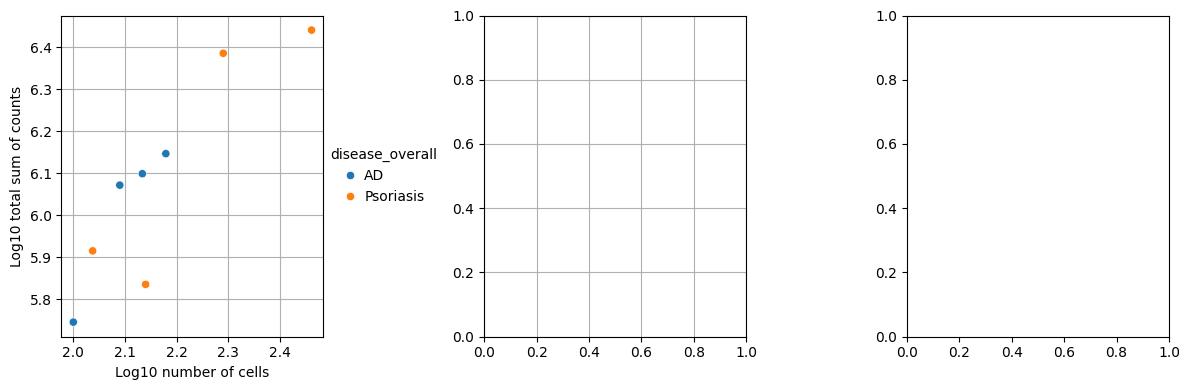

In [115]:
try:
    ps.plot_psbulk_samples(pdata, groupby=["disease_overall", "Major celltype", "Cluster"], figsize=(12, 4)) #"Patient", 
except:
    1

## Axes of variation

In [116]:
pdata.layers["counts"] = pdata.X.copy()

sc.pp.normalize_total(pdata, target_sum=1e4)
sc.pp.log1p(pdata)
sc.pp.scale(pdata, max_value=10)
sc.tl.pca(pdata)

dc.swap_layer(pdata, "counts", X_layer_key=None, inplace=True)


In [117]:
adata

AnnData object with n_obs × n_vars = 336697 × 32732
    obs: 'Site_status', 'Patient', 'Sample', 'Group', 'Major celltype', 'Cluster', 'disease_overall'
    uns: 'QC_mid_colors', 'leiden_res0.1', 'leiden_res0.1_colors', 'lvl0_colors', 'lvl4_annotation_colors', 'neighbor_20', 't_colors', 'umap'
    obsm: 'X_scvi', 'X_umap'
    layers: 'counts'
    obsp: 'neighbor_20_connectivities', 'neighbor_20_distances'

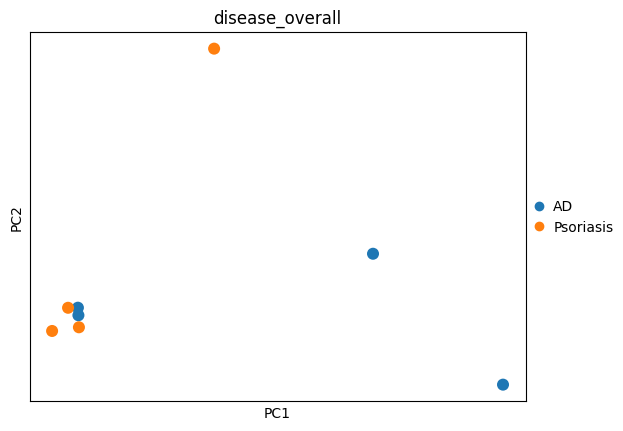

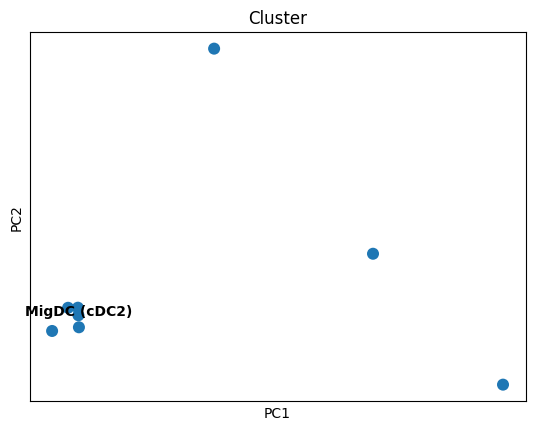

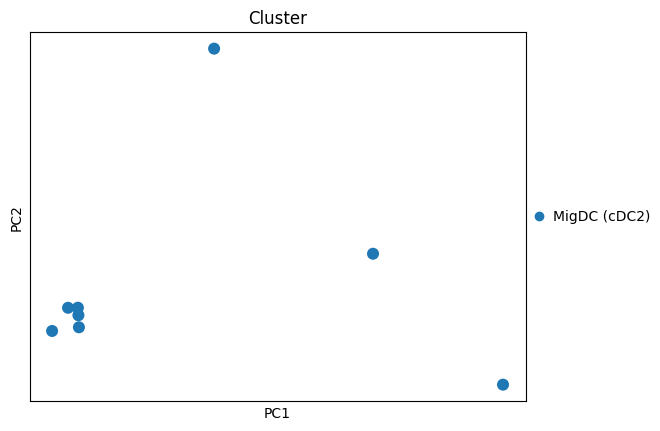

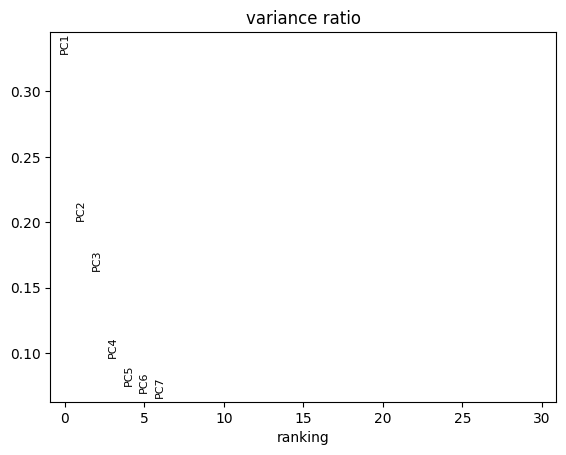

In [120]:
pdata

AnnData object with n_obs × n_vars = 8 × 16699
    obs: 'disease_overall', 'Patient', 'Site_status', 'Sample', 'Group', 'Cluster', 'psbulk_n_cells', 'psbulk_counts'
    var: 'mean', 'std'
    uns: 'log1p', 'pca', 'disease_overall_colors', 'Cluster_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'psbulk_props', 'counts'

In [121]:
# try:
#     dc.get_metadata_associations(
#         pdata,
#         obs_keys=[ "disease_overall", "Patient", "psbulk_n_cells", "psbulk_counts"], # "Treatment", "Patient",
#         obsm_key="X_pca",
#         uns_key="pca_anova",
#         inplace=True,
#     )
#     pdata
# except:
#     1

In [122]:
1

1

In [123]:
# try:
#     dc.plot_associations(
#         pdata,
#         uns_key="pca_anova",
#         obsm_key="X_pca",
#         stat_col="p_adj",
#         obs_annotation_cols=["disease_overall",  #"Treatment", "Efficacy", 
#                              "Major celltype"],
#         titles=["Principle component scores", "Adjusted p-values from ANOVA"],
#     )
# except:
#     1

## Differential expression testing with edgeR

In [ ]:
edgr = pt.tl.PyDESeq2(adata=pdata, design="~disease_overall")


In [126]:
edgr.fit()


Fitting size factors...
... done in 0.01 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 3.21 seconds.

Fitting dispersion trend curve...
... done in 0.30 seconds.

Fitting MAP dispersions...
... done in 4.65 seconds.

Fitting LFCs...
... done in 2.75 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.



In [128]:
res_df = edgr.test_contrasts(edgr.contrast(column="disease_overall", baseline="AD", group_to_compare="Psoriasis"))


Running Wald tests...


Log2 fold change & Wald test p-value, contrast vector: [0. 1.]
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG      141.596293        0.385424  0.545641  0.706369  0.479959  0.984836
A1BG-AS1    4.157831       -1.262122  1.219608 -1.034859  0.300735  0.984836
A2M        42.985584        1.251265  0.746613  1.675923  0.093753  0.984836
A2M-AS1     0.669626        0.532806  1.904485  0.279764  0.779659  0.984836
A2ML1       0.384884        1.830323  3.349142  0.546505  0.584719  0.984836
...              ...             ...       ...       ...       ...       ...
ZXDB        2.783570        0.786574  0.845458  0.930352  0.352189  0.984836
ZXDC        2.225043       -0.531382  1.105544 -0.480652  0.630764  0.984836
ZYG11B      3.982667       -0.680617  1.067041 -0.637854  0.523569  0.984836
ZYX       202.318223        0.309565  0.675595  0.458211  0.646801  0.984836
ZZEF1      16.071256       -0.250674  0.520021 -0.482046  0.629774  0.984836

[16699 rows 

... done in 49.27 seconds.



,variable,baseMean,log_fc,lfcSE,stat,p_value,adj_p_value,contrast
0,CCL22,3790.553029,-1.094313,0.212235,-5.156138,2.520947e-07,0.004198,None
1,SLAMF1,54.144889,-1.733726,0.385839,-4.493394,7.009678e-06,0.037639,None
2,UCP2,199.837040,-3.020725,0.679221,-4.447338,8.694080e-06,0.037639,None
3,BCL2A1,484.584039,1.941056,0.437282,4.438914,9.041383e-06,0.037639,None
4,IL1R2,31.584527,-3.351735,0.773730,-4.331918,1.478157e-05,0.044103,None
5,CCL17,3075.122595,-3.284479,0.762175,-4.309353,1.637328e-05,0.044103,None
6,INSIG1,96.374649,1.715142,0.400567,4.281790,1.853957e-05,0.044103,None
7,LIPA,36.102593,-7.078815,1.769182,-4.001180,6.302750e-05,0.131192,None
8,FGD2,27.692939,-2.930943,0.750849,-3.903505,9.480957e-05,0.175419,None
9,PPCDC,18.980994,-2.072174,0.555766,-3.728501,1.926224e-04,0.276809,None


NaNs encountered, dropping rows with NaNs


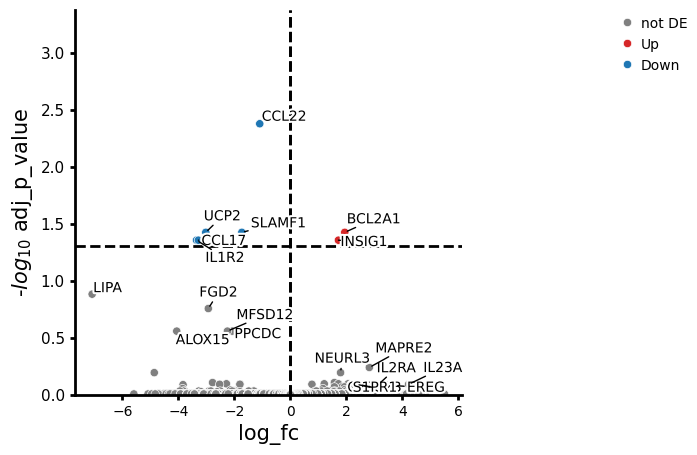

In [130]:
edgr.plot_volcano(res_df, 
                  log2fc_thresh=0,
                     to_label=10,
                  #save="fig3/3g.pdf"
                     #    log2fc_thresh=0.
                 )


NaNs encountered, dropping rows with NaNs


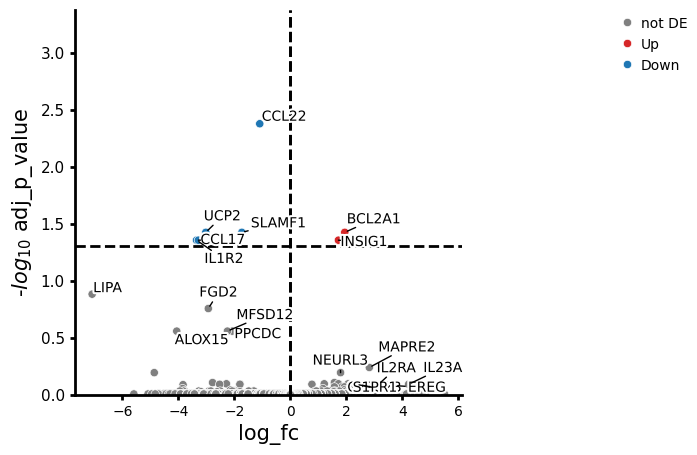

In [131]:
fig = edgr.plot_volcano(
    res_df,
    log2fc_thresh=0,
    to_label=10,
    return_fig=True
)

fig.savefig("fig3/3g.pdf", dpi=300, bbox_inches="tight")

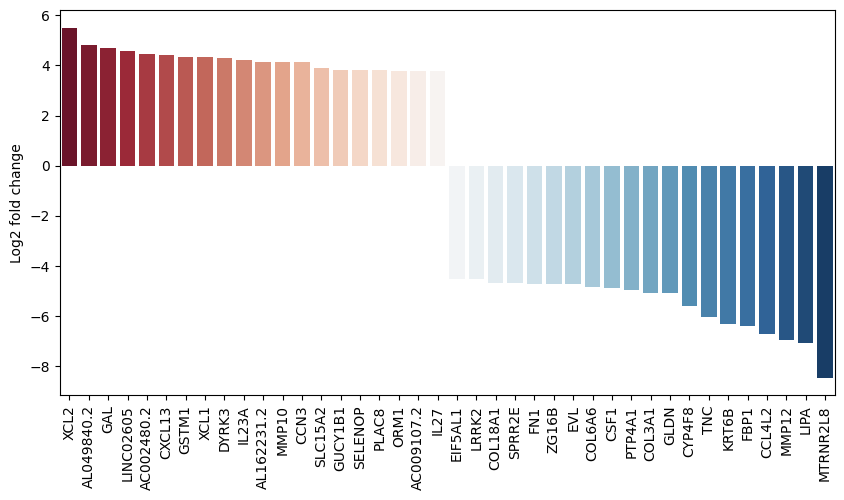

In [132]:
edgr.plot_fold_change(res_df, n_top_vars=20)
